In [1]:
import numpy as np

from tmp.config import *
import pandas
import math
from scipy.stats import mannwhitneyu

2024-08-14 01:16:41 - Start Program

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
sf=128
folder=data_dir+'Seizures/'

In [3]:
data=[]
for i in range(1,12):
    file=folder+'sz_'+str(i)+'.csv'
    a = pandas.read_csv(file,header=None).to_numpy()
    data.append(a)

In [4]:
ch_num=data[0].shape[0]
ch_types = ['eeg',]*ch_num
ch_names = ['eeg'+str(i) for i in range(ch_num)]
info = mne.create_info(ch_names=ch_names, sfreq=sf, ch_types=ch_types)

In [5]:
raw = mne.io.RawArray(data[0], info)

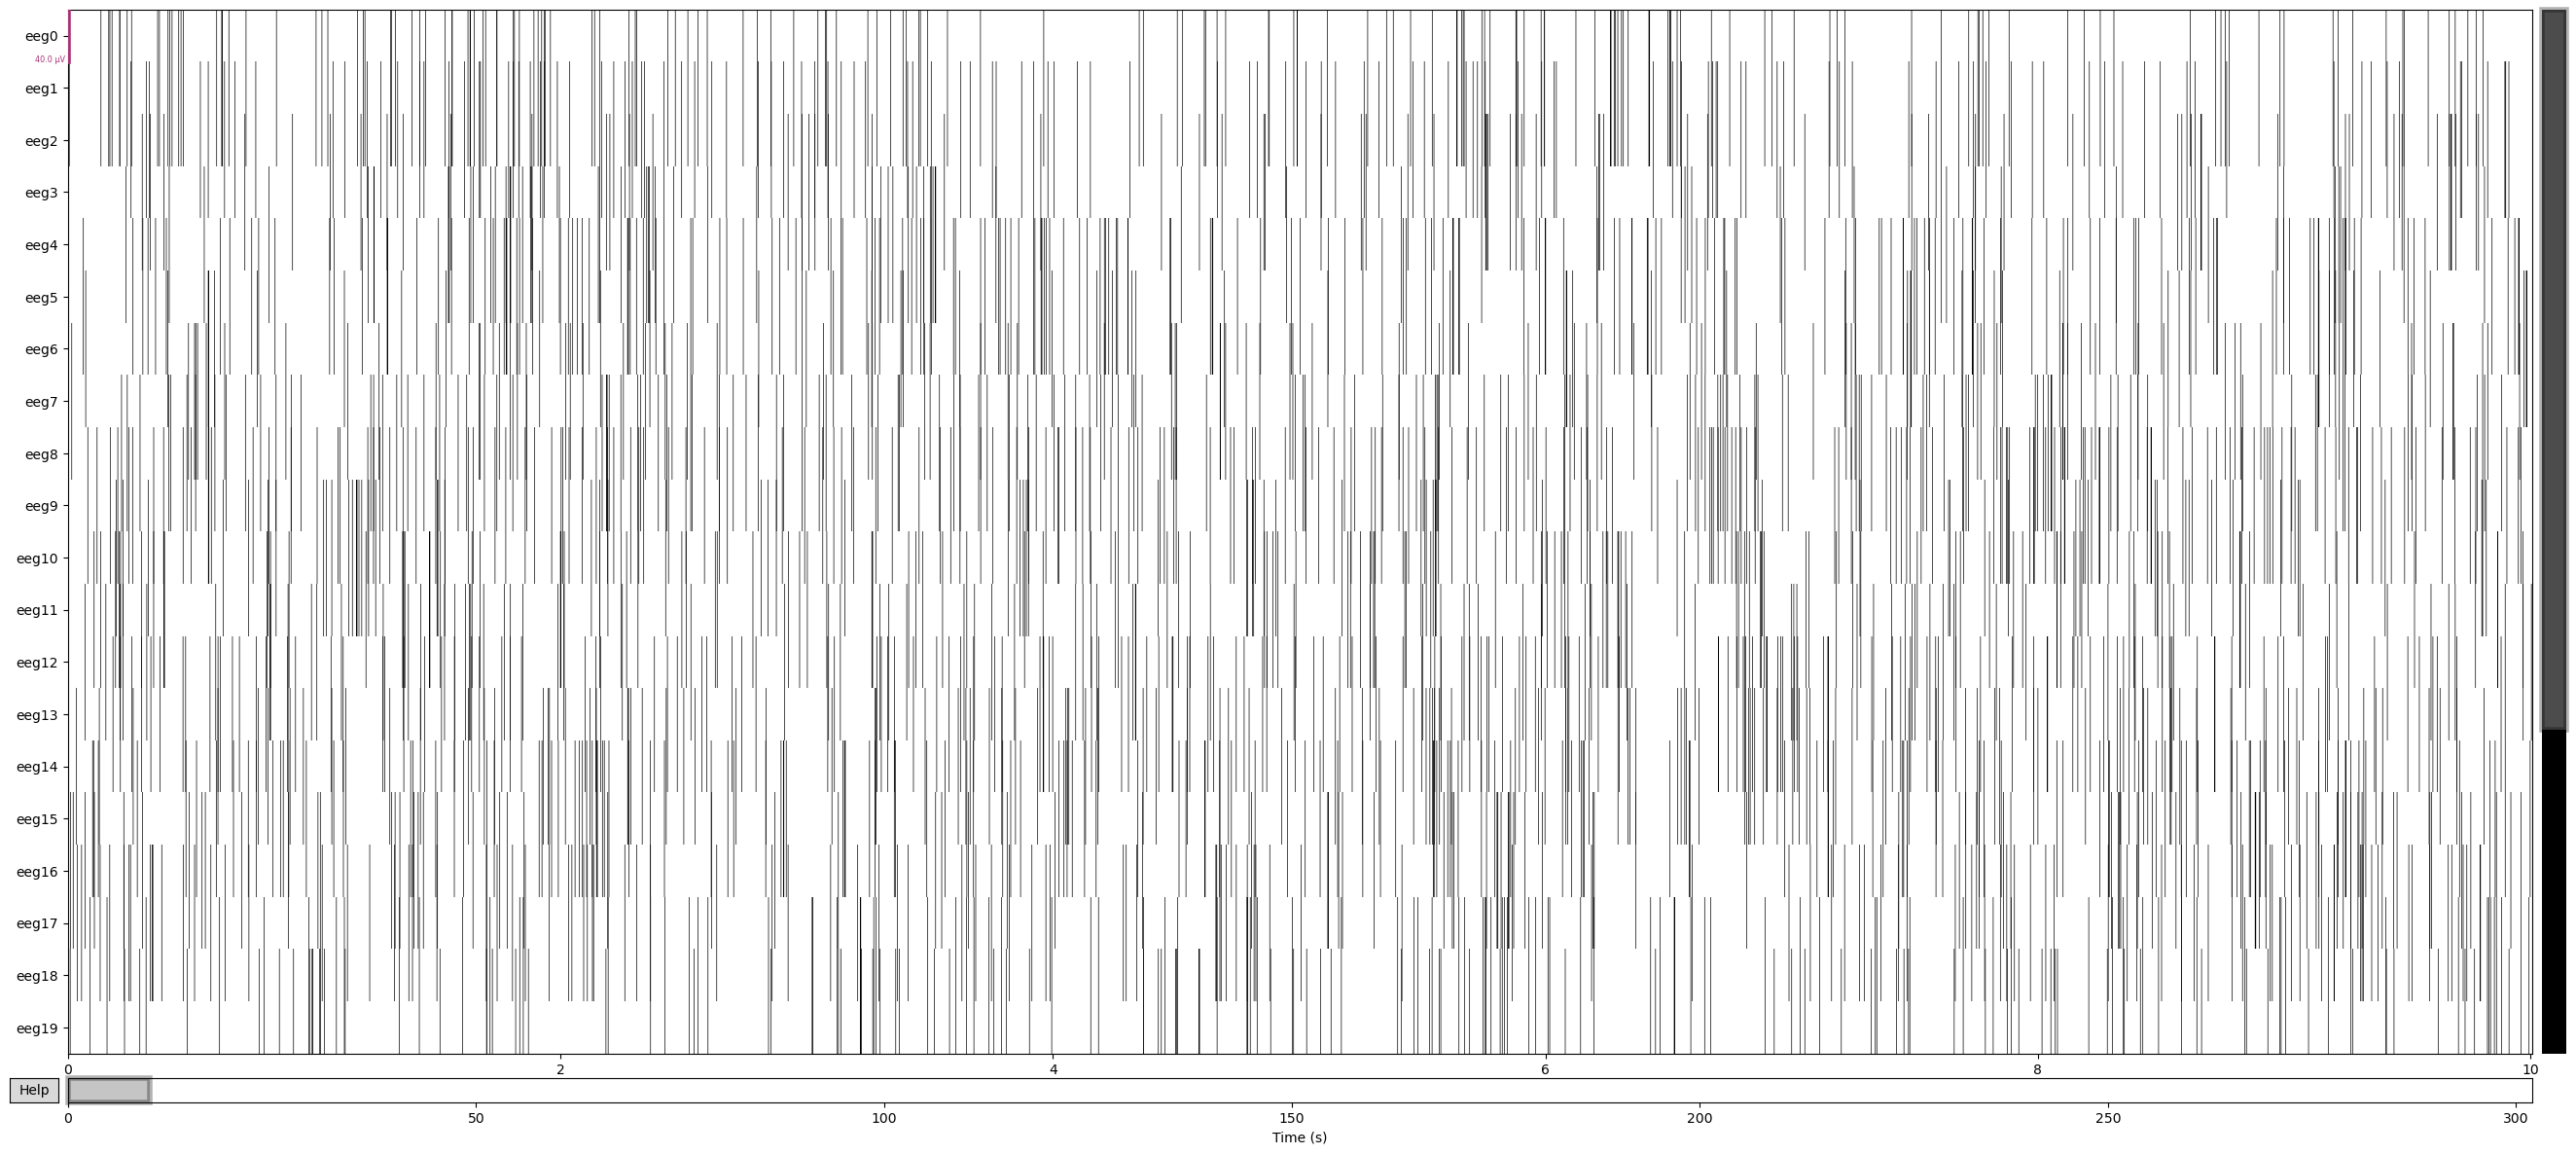

In [26]:
%matplotlib qt
raw.plot()

![](img\1.png)

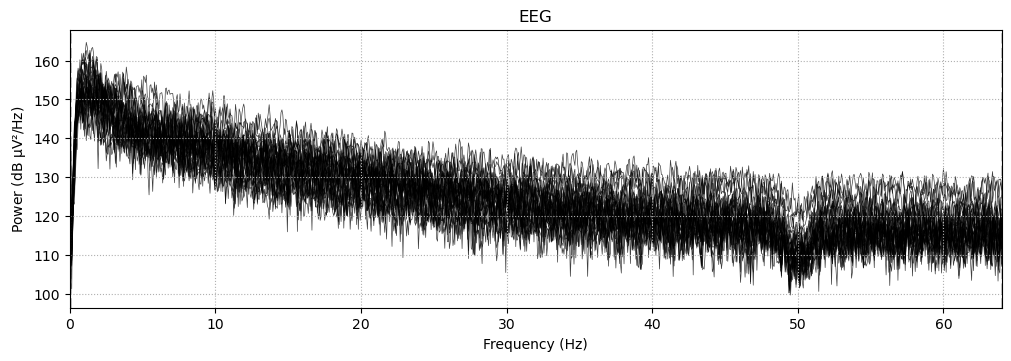

In [16]:
%matplotlib qt
raw1 = raw.copy().crop(tmin=0.0, tmax=50) # pre_ictal
raw1.compute_psd().plot()

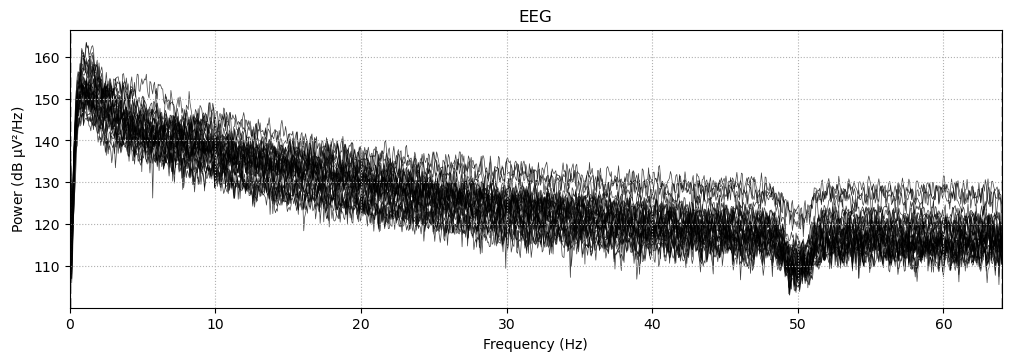

In [12]:
raw1 = raw.copy().crop(tmin=0.0, tmax=120) # Compare to previous 50s, eeg25/26/27 already have introduced high frequency component.
raw1.compute_psd().plot()

In [19]:
raw1 = raw.copy().crop(tmin=0.0, tmax=50) # To be conservative, use the first 50 s as baseline.

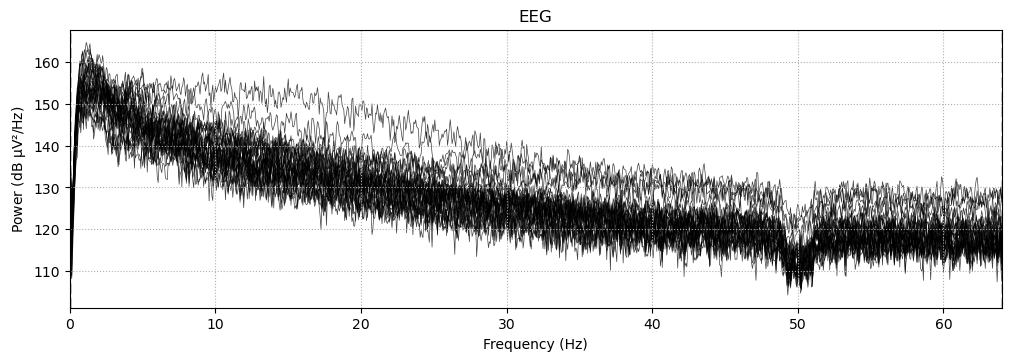

In [18]:
raw2 = raw.copy().crop(tmin=200, tmax=300) # seizure
raw2.compute_psd().plot()  # eeg 12 in low frequency; 24/25/26/27 in high frequency
#Why high frequency shows small abnormality??

PSD of eeg12 under two situations:

![](img\2.png)

### Compare the power of 20/40/60 Hz for each channel between two conditions uisng the Mann-Whitney U rank test (nonparametric).


In [3]:
f = lambda x: 10*math.log10(x)
f2 = np.vectorize(f)

sf=128
folder=data_dir+'Seizures/'

data=[]
for i in range(1,12):
    file=folder+'sz_'+str(i)+'.csv'
    a = pandas.read_csv(file,header=None).to_numpy()
    data.append(a)

ch_num=data[0].shape[0]
ch_types = ['eeg',]*ch_num
ch_names = ['eeg'+str(i) for i in range(ch_num)]
info = mne.create_info(ch_names=ch_names, sfreq=sf, ch_types=ch_types)    

In [16]:
involved_all=[]
wind=1 #ms
stride=0.4 # ms
freq_ind=60 # 20 hz
for k in range(11):
    raw = mne.io.RawArray(data[k], info)

    raw1 = raw.copy().crop(tmin=0.0, tmax=50) # pre_ictal
    total_len1=50
    raw2 = raw.copy().crop(tmin=120, tmax=raw.times[-1]) # seizure
    total_len2=raw.times[-1]-120
    
    
    steps=int((total_len1-wind)/stride)
    raw1s=[raw1.copy().crop(tmin=s*stride, tmax=(s*stride+wind)) for s in range(steps)]
    psd1s_tmp=[r.compute_psd(fmin=0, fmax=sf/2) for r in raw1s]
    steps=int((total_len2-wind)/stride)
    raw2s=[raw2.copy().crop(tmin=s*stride, tmax=(s*stride+wind)) for s in range(steps)]
    psd2s_tmp=[r.compute_psd(fmin=0, fmax=sf/2) for r in raw2s]
    frequencies=psd1s_tmp[0].freqs

    psd1s=np.asarray([f2(i.get_data()) for i in psd1s_tmp]) # (245, 29, 65)
    psd2s=np.asarray([f2(i.get_data()) for i in psd2s_tmp]) # (495, 29, 65)

    involved=[]
    
    for ch in range(ch_num):
        pre=psd1s[:,ch,freq_ind].squeeze()
        ictal=psd2s[:,ch,freq_ind].squeeze()
        U1, p = mannwhitneyu(pre, ictal)
        if p<0.05:
            involved.append(ch)
    involved_all.append(involved)   
    


In [17]:
[len(i) for i in involved_all] # check how many channels were involved:
# 20 hz: [11, 18, 12, 6, 17, 29, 29, 29, 29, 13, 29]
# 40 hz: [13, 10, 10, 11, 15, 26, 26, 27, 29, 15, 28]
# 60 hz: [9, 7, 17, 5, 14, 27, 26, 28, 28, 16, 29]

[9, 7, 17, 5, 14, 27, 26, 28, 28, 16, 29]